# Laboratorio 1 - Regresión

Este notebook tiene los siguientes elementos: 
1. Cargue de los datos.

2. Entendimiento de los datos: Describir las características más relevantes de los datos y todo el perfilamiento de datos, incluir el análisis de calidad de datos y hacer una preselección de las variables más importantes para la etapa de modelado.

3. Preparación de datos: Solucionar los problemas de calidad de datos previamente identificados que afecten el modelo a construir. Además, debe aplicar todos los proceso de preprocesamiento de datos necesarios para la construcción del modelo de regresión.

4. Modelado: Utilizando las variables previamente seleccionadas, construir un modelo de regresión que estime la variable objetivo con el menor error posible.

5. Evaluación cuantitativa: A partir de las métricas seleccionadas para evaluar y seleccionar el mejor modelo, explicar el resultado obtenido desde el punto de vista cuantitativo. Contestar a la pregunta: ¿Su equipo recomienda utilizar en producción el modelo de regresión para estimar los tiempos? ¿Por qué? En caso de no recomendar el uso del modelo, ¿qué recomendaciones haría para continuar iterando con el objetivo de la construcción de un mejor modelo?

6. Evaluación cualitativa: Debe estar compuesta de dos partes:
- Validación de supuestos: Realizar los ajustes necesarios para que el modelo cumpla con los supuestos necesarios para la inferencia estadística con regresiones.
- Interpretación de los coeficientes: Realizar la interpretación de los coeficientes de la regresión, identificando las variables más relevantes para la estimación y cómo afectan la variable objetivo.

### Entendimiento del negocio:
El caso de estudio es de un hospital que haciendo uso de la metodología KTAS quiere solicitar un modelo que pueda pronosticar el tiempo de duración de una persona en el hospital en base a sus condiciones de llegada.
### Enfoque Analitico:
En este laboratorio vamos a hacer un modelo predictivo usando un aprendizaje supervisado y un modelo de regresión lineal para hacer uso de las condiciones de llegada de los pacientes y predecir la duración de su estancia en el hospital en minutos.


## 1. Carga de los datos

In [69]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.stats as stats
import scipy.optimize as optimize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import contractions
import re, string, unicodedata
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer



In [3]:
datos = pd.read_csv("./data/Regresión_train_data.csv")

In [4]:
datos.shape

(1000, 23)

In [5]:
datos.dtypes

Grupo                         int64
Sexo                          int64
Edad                          int64
Modo_Llegada                  int64
Lesion                        int64
Queja_Principal              object
Estado_Mental                 int64
Dolor                         int64
dolor_NRS                    object
SBP                         float64
DBP                         float64
HR                          float64
RR                          float64
BT                          float64
Saturacion                  float64
KTAS_enfermera                int64
Diagnostico_En_Urgencias     object
Disposicion                   int64
KTAS_experto                  int64
Grupo_De_Error                int64
Duracion_Estancia_Min         int64
Duracion_KTAS_Min            object
Error_Triaje                  int64
dtype: object

In [6]:
datos.sample(5)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,BT,Saturacion,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje
470,2,2,51,4,1,ant. chest pain,1,1,5,120.0,...,36.4,99.0,2,Unstable angina,1,2,0,7937,"4,00",0
227,1,1,40,1,1,Rt abd pain,1,1,3,101.0,...,36.2,NaN,4,Herpes zoster,1,4,0,23,"7,13",0
48,2,2,45,4,1,syncope,1,0,#BOÞ!,100.0,...,36.4,98.0,3,Syncope,2,3,0,699667,"5,00",0
613,2,2,41,3,1,abd pain,1,1,3,110.0,...,36.2,98.0,4,"Malignant neoplasm of body of stomach, early",2,4,0,944,"3,00",0
864,1,2,59,3,1,"distension, abd",1,0,#BOÞ!,91.0,...,36.8,NaN,5,Alcoholic hepatitis with ascites,1,5,0,215,"12,83",0


## 2. Entendimiento de los datos

Se nos proporcionaron dos CSVs, uno para entrenar el modelo y otro para probarlo, al analizar los datos dados en el csv de entrenamiento seguimos los siguientes pasos:

In [7]:
datos.describe()

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Estado_Mental,Dolor,SBP,DBP,HR,RR,BT,Saturacion,KTAS_enfermera,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Error_Triaje
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,983.000000,979.000000,988.000000,985.000000,989.000000,444.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.450000,1.514000,53.892000,2.811000,1.2000,1.103000,0.562000,133.485249,79.566905,84.400810,19.450761,36.562993,97.047297,3.328000,1.610000,3.260000,0.569000,12792.480000,0.253000
std,0.497743,0.500054,19.826483,0.796186,0.4002,0.431946,0.496389,27.156136,15.174593,16.297428,2.069882,0.519699,4.761112,0.862067,1.161572,0.865534,1.587375,87721.151446,0.630387
min,1.000000,1.000000,16.000000,1.000000,1.0000,1.000000,0.000000,50.000000,31.000000,32.000000,14.000000,35.000000,20.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,36.000000,2.000000,1.0000,1.000000,0.000000,114.000000,70.000000,73.000000,18.000000,36.200000,97.000000,3.000000,1.000000,3.000000,0.000000,132.750000,0.000000
50%,1.000000,2.000000,56.000000,3.000000,1.0000,1.000000,1.000000,130.000000,80.000000,82.000000,20.000000,36.500000,98.000000,3.000000,1.000000,3.000000,0.000000,270.500000,0.000000
75%,2.000000,2.000000,70.250000,3.000000,1.0000,1.000000,1.000000,150.000000,90.000000,96.000000,20.000000,36.800000,99.000000,4.000000,2.000000,4.000000,0.000000,620.000000,0.000000
max,2.000000,2.000000,94.000000,7.000000,2.0000,4.000000,1.000000,275.000000,160.000000,148.000000,30.000000,39.800000,100.000000,5.000000,7.000000,5.000000,9.000000,709510.000000,2.000000


En el CSV hay datos de 1000 pacientes, con 23 caracteristicas independientes.

Se puede ver que un 75% de los valores de la variable objetivo "Duracion_Estancia_Min" estan sobre los 620 minutos (10 horas y 20 minutos), sin embargo hay datos que alcanzan hasta los 709,510 minutos (1 año y 127 días).

Al ver los atributos de cada una de las filas agrupamos las carateristicas de la sigueinte manera.

| Category |Fields|
|----------|------|
| Demografía |Sexo, Edad, Grupo|
| Accidente |Modo Llegada, Lesión, Queja, Principal|
| Signos Vitales |Estado Mental, SBP, DBP, HR, RR, BT, Saturación, Dolor|
| Diagnósticos |dolor NRS, KTAS enfermera, Diagnóstico En Urgencias, Disposición, KTAS experto, Duración_Estancia_Min, Duración_KTAS_Min, Error_Triaje|

Lo que nos dice es que una fila de los datos que tiene información de un paciente se compone de su demografia, accidente, los signos vitales y el dignostico que le dió en el ala de urgencias.
Entré las caraterisiticas mas relevantes se encuentran:
- Los signos vitales: Estado mental, presión Arterial Sistólica, Presión Arterial Diastólica, Frecuencia cardíaca, Frecuencia Respiratoria, Temperatura Corporal y Saturación de Oxígeno.
- La edad de los pacientes.
- El Triaje realizado por la enfermera y los expertos.
- El modo en el que llevan al hospital.

Se realiza un analisis de completitud en el que podemos ver que todos los datos están completos, cuentan con 1000 registros, menos los signos vitales. El mas detacado es la saturación que un 50% de los datos no cuenta con este valor. El resto de los signos vitales no supera el 20% de faltantes. Creemos que la toma de estos signos está relacionada con la gravedad del estado del paciente.

In [8]:
datos.isnull().sum() / datos.shape[0]

Grupo                       0.000
Sexo                        0.000
Edad                        0.000
Modo_Llegada                0.000
Lesion                      0.000
Queja_Principal             0.000
Estado_Mental               0.000
Dolor                       0.000
dolor_NRS                   0.000
SBP                         0.017
DBP                         0.021
HR                          0.012
RR                          0.015
BT                          0.011
Saturacion                  0.556
KTAS_enfermera              0.000
Diagnostico_En_Urgencias    0.001
Disposicion                 0.000
KTAS_experto                0.000
Grupo_De_Error              0.000
Duracion_Estancia_Min       0.000
Duracion_KTAS_Min           0.000
Error_Triaje                0.000
dtype: float64

Los datos de la variable dolor_NRS están completos, no hay nulos, pero casi el 44% de los datos está marcado con #BOÞ!.

In [9]:
datos["dolor_NRS"].value_counts()/datos.shape[0]

dolor_NRS
#BOÞ!    0.440
3        0.209
4        0.111
5        0.109
6        0.059
2        0.031
7        0.027
8        0.008
10       0.003
1        0.002
9        0.001
Name: count, dtype: float64

La Duracion_KTAS_Min se encuentra guardada como object y nó como float64. Se decide realizar este cambio para poder contininuar con el entendimiento de los datos.

In [10]:
datos["Duracion_KTAS_Min"] = datos["Duracion_KTAS_Min"].str.replace(',', '.').astype('float64')

### 2.1. Búsqueda de relaciones con la variable objetivo

Si se logra visualizar o cuantificar altas correlaciones entre las variables de entrada y la variable objetivo, se podrán soportar las decisiones del experto con base en la evidencia.

Para fines practicos se extrae en una lista todas las variables numericas que se pueden procesar.

In [11]:
numericas = ["Grupo", "Sexo", "Edad",  "Modo_Llegada", "Lesion", "Estado_Mental", "Dolor","KTAS_enfermera", "SBP", "DBP", "HR", "RR", "BT", "Saturacion", "Disposicion", "KTAS_experto", "Duracion_KTAS_Min", "Duracion_Estancia_Min"]

Dado que existen una gran brecha entre la duración de la estancia, que el 75% está por debajo de 700 y después de esos se dipara, tomamos la desición de no contar con esos datos para poder seguir con el entendimiento. Como se puede ver acontinuacion. los datos crecen de forma razonable hasta cierto punto.

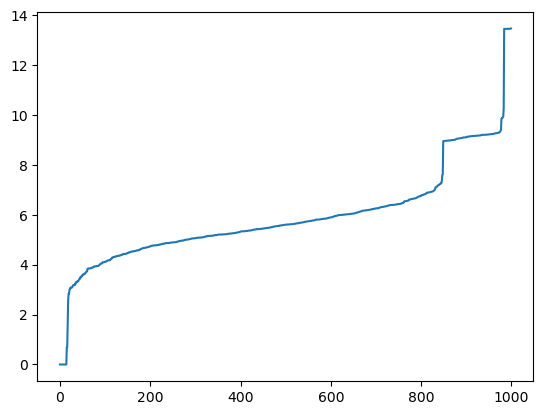

In [12]:
plt.plot(np.log(np.sort(datos["Duracion_Estancia_Min"]+1)))

<Axes: ylabel='Duracion_Estancia_Min'>

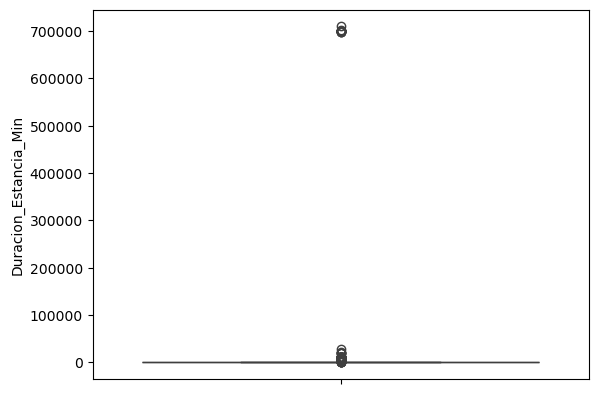

In [13]:
sns.boxplot(datos["Duracion_Estancia_Min"])

Para continuar con el entendimiento se decide tomar el percentil 0.8 de los datos, lo que equivale a todas las filas que el tiempo de su estancia sea menor a 858 minutos, lo que nos dá unos datos menos dispersos y manejables. 

(800, 23)
858.0000000000002


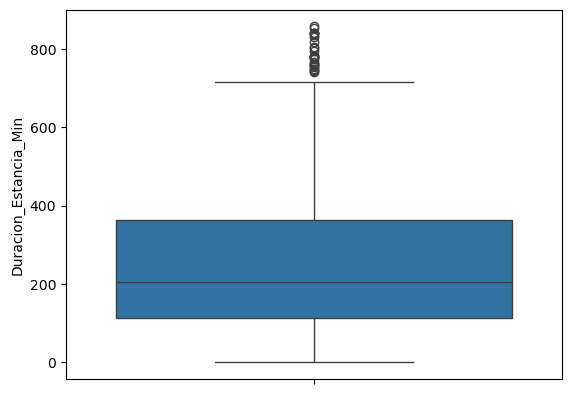

In [14]:
val = datos["Duracion_Estancia_Min"].quantile(0.8)
datos_recorte =datos[datos["Duracion_Estancia_Min"]<=val]
sns.boxplot(datos_recorte["Duracion_Estancia_Min"])
print(datos_recorte.shape)
print(val)

Realizamos una grafica scatter por cada variable numerica para tratar de ver tendencias de comportamiento de los datos

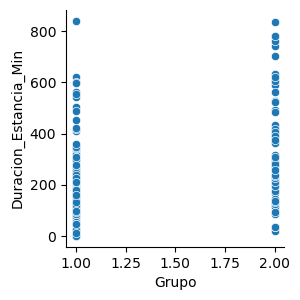

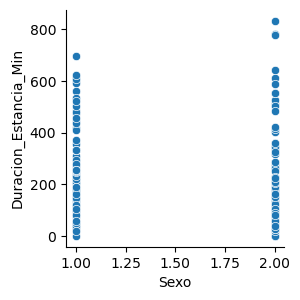

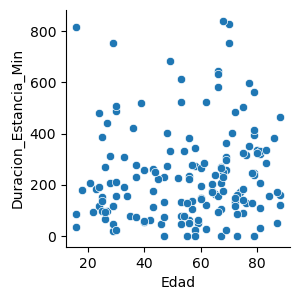

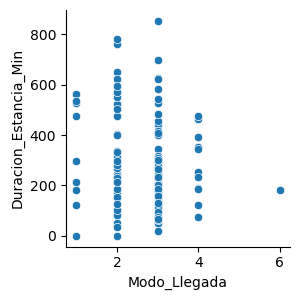

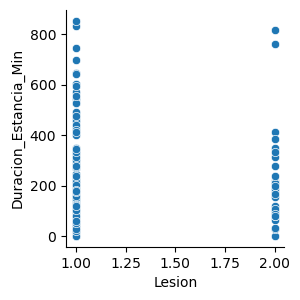

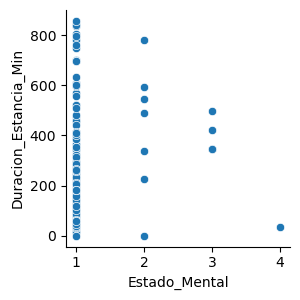

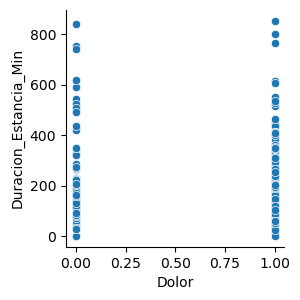

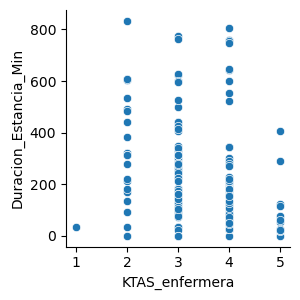

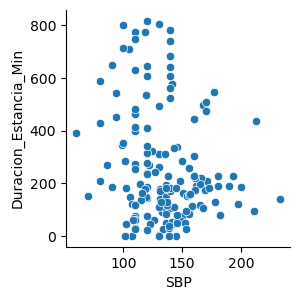

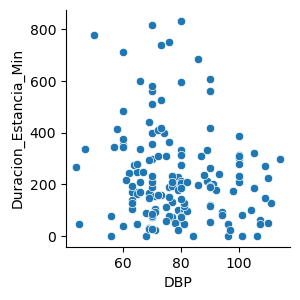

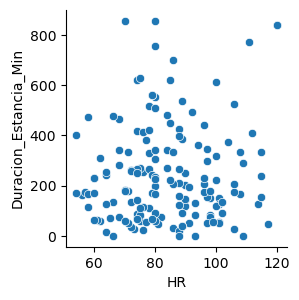

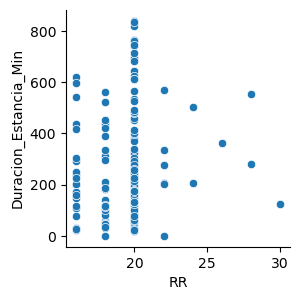

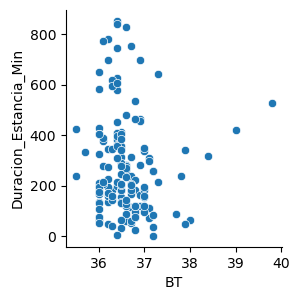

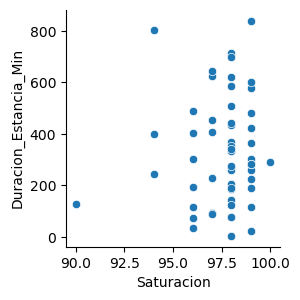

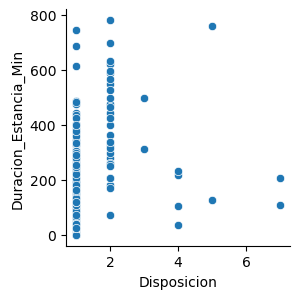

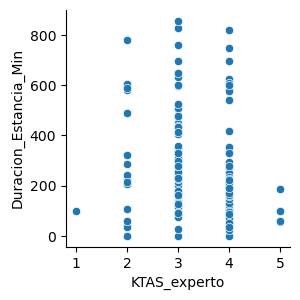

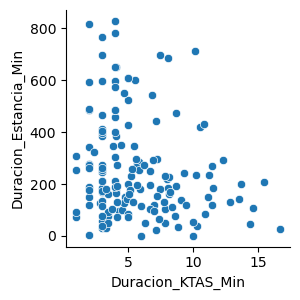

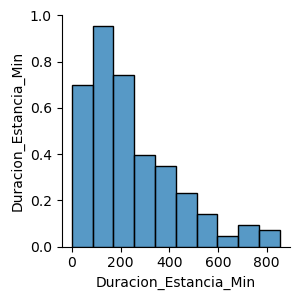

In [15]:
for variable in numericas:
    sns.pairplot(datos_recorte.sample(frac=0.2), height=3, y_vars="Duracion_Estancia_Min", x_vars=variable, kind="scatter")

Lo mas notable de estos graficos y que usaremos luego, es una posible distribución logaritmica normal de la variable de Duracion_KTAS_Min contra Duracion_Estancia_Min.

Probamos con todos los datos y su relacion con la variable objetivo, se puede apreciar que ninguna de las variables, obviando "Grupo", superan el 5% de coeficiente de correlación.

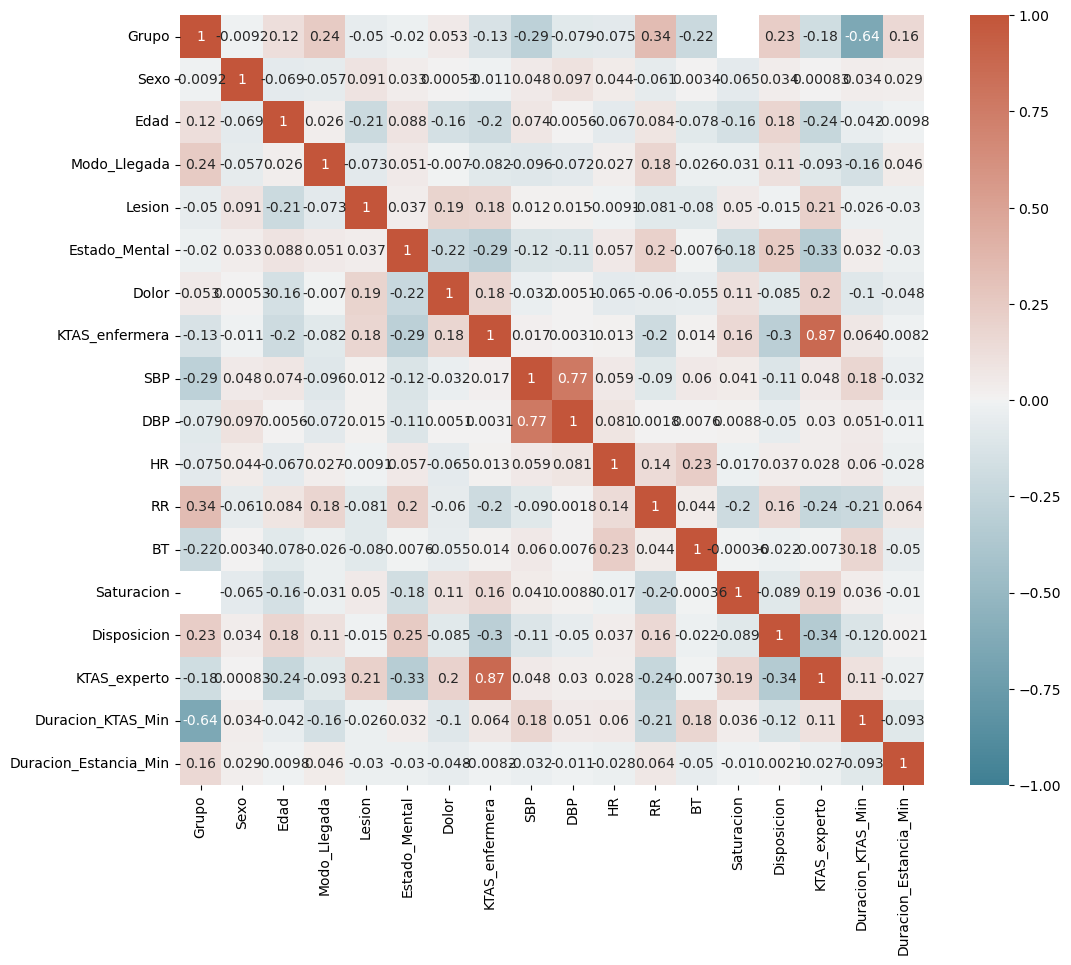

In [16]:
plt.figure(figsize=(12, 10))
cmap = sns.diverging_palette(220, 20, as_cmap=True)

sns.heatmap(
    datos[numericas].corr(),
    cmap=cmap,
    vmin=-1, vmax=1,
    annot=True
)

plt.show()

Ahora haciendo uso del recorte, las correlaciones aumentan significativamente, sin embargo siguen habiendo correlaciones bastante poco significativas (no superiores al 25%).

Las variables que mas relaciones tienen son Grupo: 40%, Lesion: 16%, KTAS_experto: 24%, edad: 21%, la disposicion: 18% y la duración del KTAS: 20%. Los signos vitales son muy dispersos y podemos optar por unirlos.

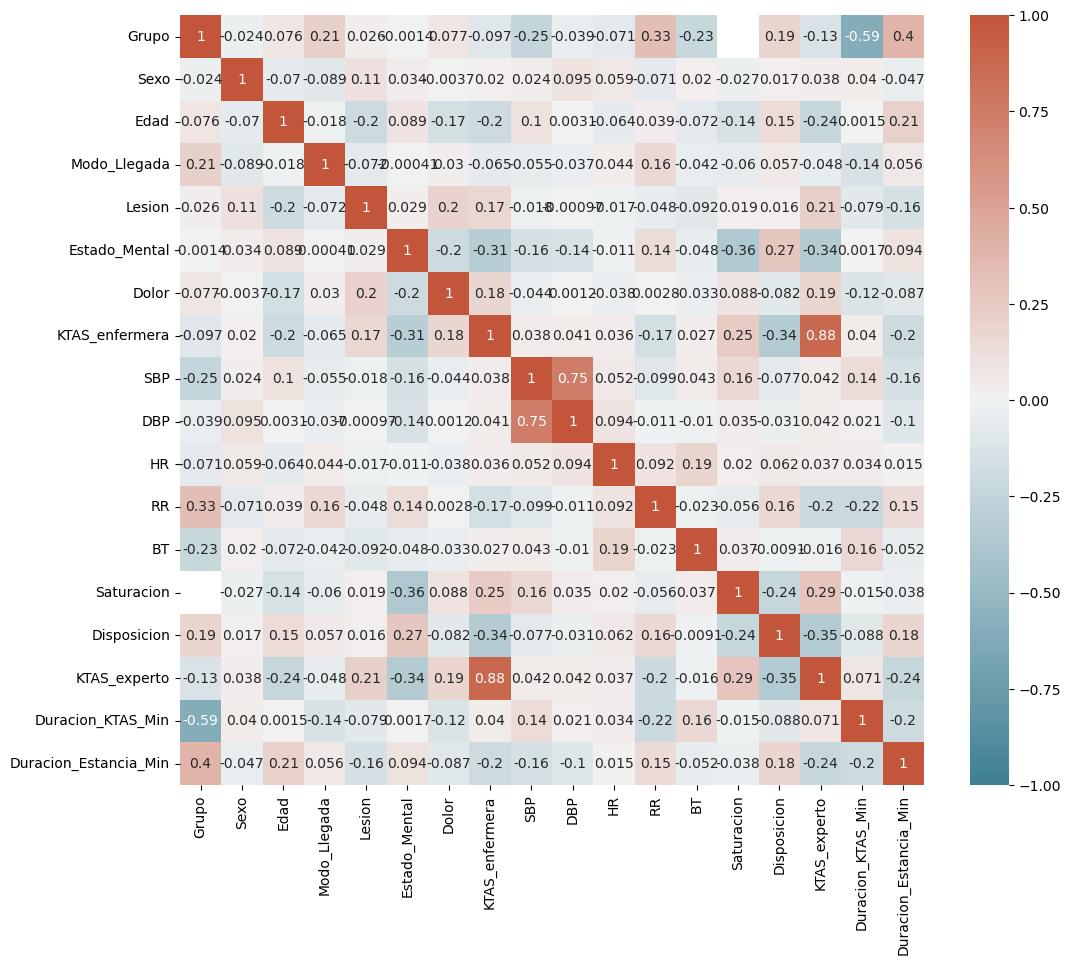

In [17]:
plt.figure(figsize=(12, 10))
cmap = sns.diverging_palette(220, 20, as_cmap=True)

sns.heatmap(
    datos_recorte[numericas].corr(),
    cmap=cmap,
    vmin=-1, vmax=1,
    annot=True
)

plt.show()

En la preseleccion de los datos elegimos las variables mas relevantes con relacion a la objetivo.

In [18]:
candidatas = ["Grupo", "Lesion","KTAS_experto","Disposicion",  "Edad", "Duracion_KTAS_Min"]


## 3. Preparación de datos

Problemas de calidad:

Primero el dolor reportado por la enfermera, el cual tiene un 44% de sus entradas en null.
Nos dimos cuenta de que estas se correspondian cuando el paciente no tenia dolor, por lo que las asignamos a 0. Esto tenia una excepcion en 2 entradas, las cuales registraban que el paciente tenia dolor, pero no especificaba cual por lo que le asignamos la media.

In [19]:
def calida_dolor_NRS(registro):
    if registro["dolor_NRS"] == "#BOÞ!" and registro["Dolor"] == 0:
        return 0
    elif registro["dolor_NRS"] == "#BOÞ!" and registro["Dolor"] != 0:
        return registro["dolor_NRS"]
    return int(registro["dolor_NRS"])
datos['dolor_NRS'] = datos.apply(calida_dolor_NRS, axis=1)

mean = datos[datos["dolor_NRS"] != "#BOÞ!" ]['dolor_NRS'].mean()
datos["dolor_NRS"] = datos["dolor_NRS"].apply(lambda x: round(mean) if x == "#BOÞ!" else x)
datos["dolor_NRS"].value_counts()

dolor_NRS
0     438
3     209
4     111
5     109
6      59
2      33
7      27
8       8
10      3
1       2
9       1
Name: count, dtype: int64

Despues usamos la tecnica del One-Hot, para estandarizar el Sexo y la Lesion.

In [20]:
datos["Sexo_stan"] = datos["Sexo"].apply(lambda x: 0 if x == 2 else x)
datos["Sexo_stan"].value_counts()

Sexo_stan
0    514
1    486
Name: count, dtype: int64

In [21]:
datos["Lesion_stan"]=datos["Lesion"].apply(lambda x:0 if x == 2 else x)
datos["Lesion_stan"].value_counts()

Lesion_stan
1    800
0    200
Name: count, dtype: int64

Hicimos una investigación para agrupar los signos vitales en esta y llegamos al Early Warning Score (EWS) es una herramienta clínica utilizada para identificar a los pacientes que están en riesgo de deterioro. El cálculo del EWS generalmente se basa en una serie de parámetros fisiológicos como la frecuencia cardíaca, la presión arterial, la temperatura, la frecuencia respiratoria, y el nivel de conciencia, la calculamos y la agregamos a los datos.

In [22]:
def calcularEWS(registro):
    total = 0
    
    # Frecuencia respiratoria (RR)
    if registro.get('RR', np.nan) <= 8:
        total += 2
    elif 9 <= registro.get('RR', np.nan) <= 14:
        total += 0
    elif 15 <= registro.get('RR', np.nan) <= 20:
        total += 1
    elif 21 <= registro.get('RR', np.nan) <= 29:
        total += 2
    elif registro.get('RR', np.nan) >= 30:
        total += 3
    
    # Presión arterial sistólica (SBP)
    if registro.get('SBP', np.nan) <= 70:
        total += 3
    elif 71 <= registro.get('SBP', np.nan) <= 80:
        total += 2
    elif 81 <= registro.get('SBP', np.nan) <= 100:
        total += 1
    elif 101 <= registro.get('SBP', np.nan) <= 199:
        total += 0
    elif registro.get('SBP', np.nan) >= 200:
        total += 2

    # Frecuencia cardíaca (HR)
    if registro.get('HR', np.nan) <= 40:
        total += 2
    elif 41 <= registro.get('HR', np.nan) <= 50:
        total += 1
    elif 51 <= registro.get('HR', np.nan) <= 100:
        total += 0
    elif 101 <= registro.get('HR', np.nan) <= 110:
        total += 1
    elif 111 <= registro.get('HR', np.nan) <= 129:
        total += 2
    elif registro.get('HR', np.nan) >= 130:
        total += 3

    # Temperatura corporal (BT)
    if registro.get('BT', np.nan) < 35.0:
        total += 2
    elif 35.0 <= registro.get('BT', np.nan) <= 38.4:
        total += 0
    elif registro.get('BT', np.nan) >= 38.5:
        total += 2

    # Saturación de oxígeno (Saturacion)
    if registro.get('Saturacion', np.nan) <= 91:
        total += 3
    elif 92 <= registro.get('Saturacion', np.nan) <= 93:
        total += 2
    elif 94 <= registro.get('Saturacion', np.nan) <= 95:
        total += 1

    # Nivel de conciencia
    if registro.get('Estado_Mental', np.nan) == 1:
        total += 0
    elif registro.get('Estado_Mental', np.nan) == 2:
        total += 1
    elif registro.get('Estado_Mental', np.nan) == 3:
        total += 2
    elif registro.get('Estado_Mental', np.nan) == 4:
        total += 3

    return total

datos['EWS'] = datos.apply(calcularEWS, axis=1)
datos.head()

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,Sexo_stan,Lesion_stan,EWS
0,2,2,49,2,1,ant. chest pain,1,1,2,150.0,...,Ischaemic chest pain,2,2,0,1591,2.0,0,0,1,1
1,2,2,30,4,1,headache,1,1,4,140.0,...,"Subarachnoid haemorrhage, unspecified",7,3,0,211,3.0,0,0,1,1
2,2,1,61,3,2,ant. chest pain,1,1,3,100.0,...,Contusion of front wall of thorax,1,4,0,119,2.0,0,1,0,2
3,2,2,61,3,1,headache,1,1,4,120.0,...,Headache,1,3,4,414,2.0,2,0,1,1
4,1,2,67,3,1,fever & chill,1,0,0,143.0,...,Fever,1,2,1,267,3.6,2,0,1,4


Por ultimo intentamos linealizar la "Duracion_KTAS_Min".

In [23]:
datos["Dur_KTAS_lin"] = np.log(datos["Duracion_KTAS_Min"])

In [24]:
numericas = ["Grupo", "Sexo", "Edad",  "Modo_Llegada", "Lesion","Lesion_stan", "Estado_Mental", "Dolor","KTAS_enfermera", "EWS", "Disposicion", "KTAS_experto", "Duracion_KTAS_Min","Dur_KTAS_lin", "Duracion_Estancia_Min"]

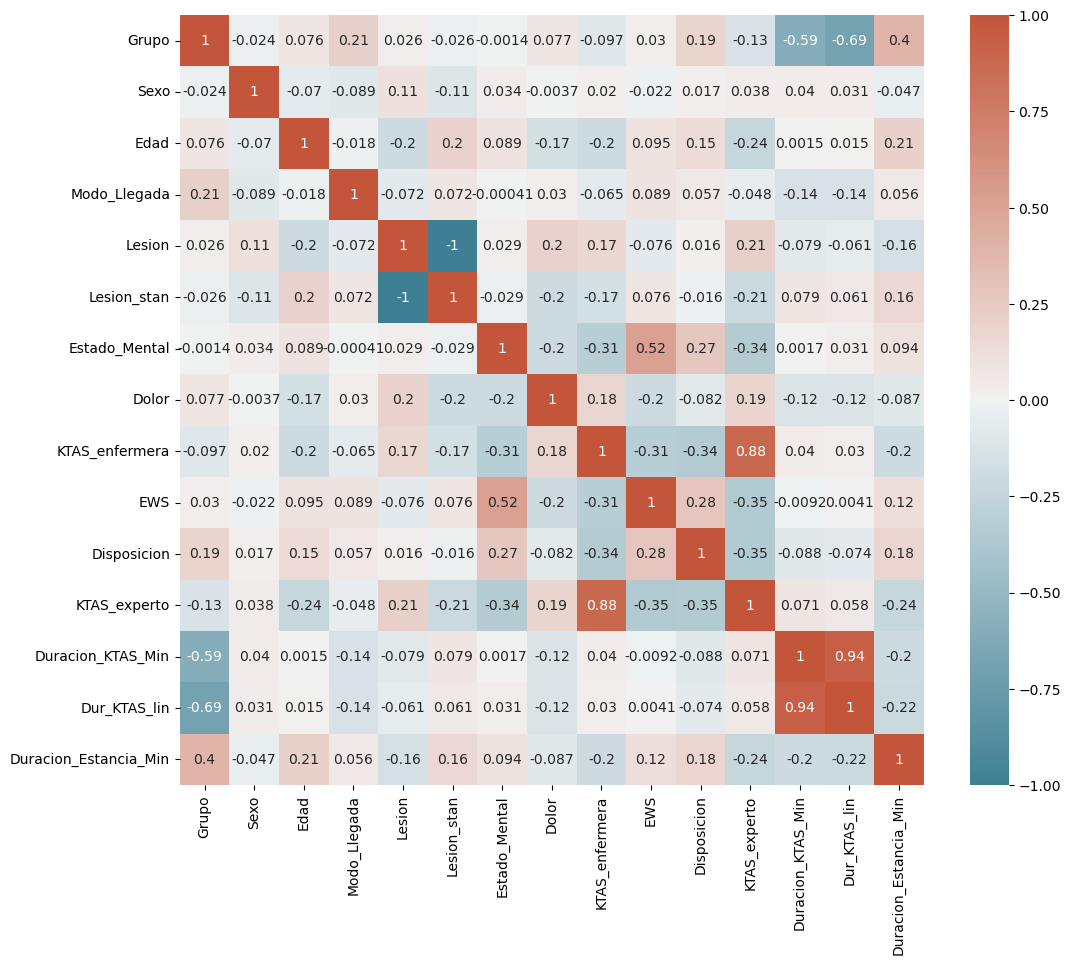

In [25]:
val = datos["Duracion_Estancia_Min"].quantile(0.8)
datos_recorte =datos[datos["Duracion_Estancia_Min"]<=val]
plt.figure(figsize=(12, 10))
cmap = sns.diverging_palette(220, 20, as_cmap=True)

sns.heatmap(
    datos_recorte[numericas].corr(),
    cmap=cmap,
    vmin=-1, vmax=1,
    annot=True
)

plt.show()

Usando este nuevo heatmap tenemos las siguientes variables candidatas.

In [26]:
candidatas = ["Grupo", "Edad", "Disposicion", "Lesion_stan","KTAS_experto","EWS", "Dur_KTAS_lin"]

Hacemos una limpieza de duplicados:

In [27]:
# Se eliminan los registros totalmente duplicados
datos = datos.dropna(subset=["Duracion_Estancia_Min"]+candidatas)

In [28]:
datos.shape

(1000, 27)

In [29]:
total_rows = datos.shape[0]

No se hay duplicados totales.

In [30]:
datos[["Duracion_Estancia_Min"]+candidatas].isnull().sum() / datos.shape[0]

Duracion_Estancia_Min    0.0
Grupo                    0.0
Edad                     0.0
Disposicion              0.0
Lesion_stan              0.0
KTAS_experto             0.0
EWS                      0.0
Dur_KTAS_lin             0.0
dtype: float64

Duplicados parciales:

In [31]:
datos.loc[datos.duplicated(subset=candidatas, keep=False)][["Duracion_Estancia_Min"]+candidatas].head(10)

,Duracion_Estancia_Min,Grupo,Edad,Disposicion,Lesion_stan,KTAS_experto,EWS,Dur_KTAS_lin
8,9619,2,58,2,1,2,1,0.693147
20,129,1,78,1,1,3,2,1.682688
22,10210,2,82,2,1,3,1,1.386294
55,60,2,40,1,1,5,1,0.693147
60,196,2,69,1,1,3,1,1.609438
61,7985,2,51,1,1,3,1,0.693147
71,125,2,41,1,0,4,1,1.386294
87,332,1,81,1,1,3,1,1.355835
99,148,1,22,1,0,3,1,1.927164
102,75,1,28,1,1,3,1,1.121678


In [32]:
duplicated_rows = datos.loc[datos.duplicated(subset=candidatas, keep=False)].shape[0]
duplicated_rows

94

In [33]:
print(f"Duplicates: {(duplicated_rows/total_rows)*100:.4f}%")

Duplicates: 9.4000%


In [34]:
datos.loc[datos.duplicated(subset=candidatas+["Duracion_Estancia_Min"], keep=False)].tail(4)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,Sexo_stan,Lesion_stan,EWS,Dur_KTAS_lin
996,1,1,27,3,1,Suicidal Attempt,1,0,0,110.0,...,2,3,0,442,7.42,0,1,1,1,2.004179
997,1,2,54,2,1,"pain, chest",1,1,6,159.0,...,1,2,0,214,4.95,0,0,1,1,1.599388
998,1,1,19,3,1,eye discomfort,1,0,0,132.0,...,1,4,0,50,3.45,0,1,1,1,1.238374
999,1,2,29,3,1,"pain, abdominal",1,1,6,137.0,...,1,3,0,116,5.97,0,0,1,1,1.786747


In [35]:
duplicated_rows = datos.loc[datos.duplicated(subset=candidatas+["Duracion_Estancia_Min"], keep=False)].shape[0]
duplicated_rows

67

In [36]:
print(f"Duplicates: {(duplicated_rows/total_rows)*100:.4f}%")

Duplicates: 6.7000%


In [37]:
datos.drop_duplicates(subset=candidatas, inplace=True)
datos.drop_duplicates(subset=candidatas+["Duracion_Estancia_Min"], inplace=True)

In [38]:
datos.shape

(952, 27)

Aquí hay dos escenarios a analizar:
1. Existe 94 reguistos o un ~9.4% de registros con variables de entrada duplicadas, con variable objetivo diferente. Una cantidad es un poco preocupante que requieren ser limpiados para no confundir al modelo.

2. Al incluir la variable objetivo dentro del análisis de duplicados, se obtiene el ~6.7% registros duplicados adicionales. Esto es un problema potencial que obligaria al algoritmo de optimización a enfocarse más en aquellos registros duplicados.

In [39]:
val = datos["Duracion_Estancia_Min"].quantile(0.75)
datos_recorte =datos[datos["Duracion_Estancia_Min"]<=val]

### 3.2. Particionamiento del conjunto de datos en entrenamiento y prueba

Se desea construir un modelo que se ajuste bien a los datos de entrenamiento, pero que además se comporte de forma similar con datos previamente desconocidos.

En esta parte de dividen los datos en dos conjuntos, prueba y entrenamineto. El conjunto de prueba corresponderá al 30% de los datos limpiados previamente.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(datos_recorte[candidatas], datos_recorte["Duracion_Estancia_Min"], test_size=0.3, random_state=1)

In [41]:
X_train.shape, y_train.shape

((499, 7), (499,))

In [42]:
X_test.shape, y_test.shape


((215, 7), (215,))

## 4. Modelado

Utilizando las variables previamente seleccionadas, construir un modelo de regresión que estime la variable objetivo con el menor error posible.

In [43]:
regression = LinearRegression()
regression.fit(X_train, y_train)


LinearRegression()

## 5. Evaluación cualitativa

In [44]:
pd.DataFrame({"columns": candidatas, "coef": regression.coef_})

,columns,coef
0,Grupo,118.396624
1,Edad,1.063797
2,Disposicion,6.156596
3,Lesion_stan,54.392651
4,KTAS_experto,-34.026055
5,EWS,2.714628
6,Dur_KTAS_lin,7.380159


Train: 136.63424117782395
Test: 137.20727204530283


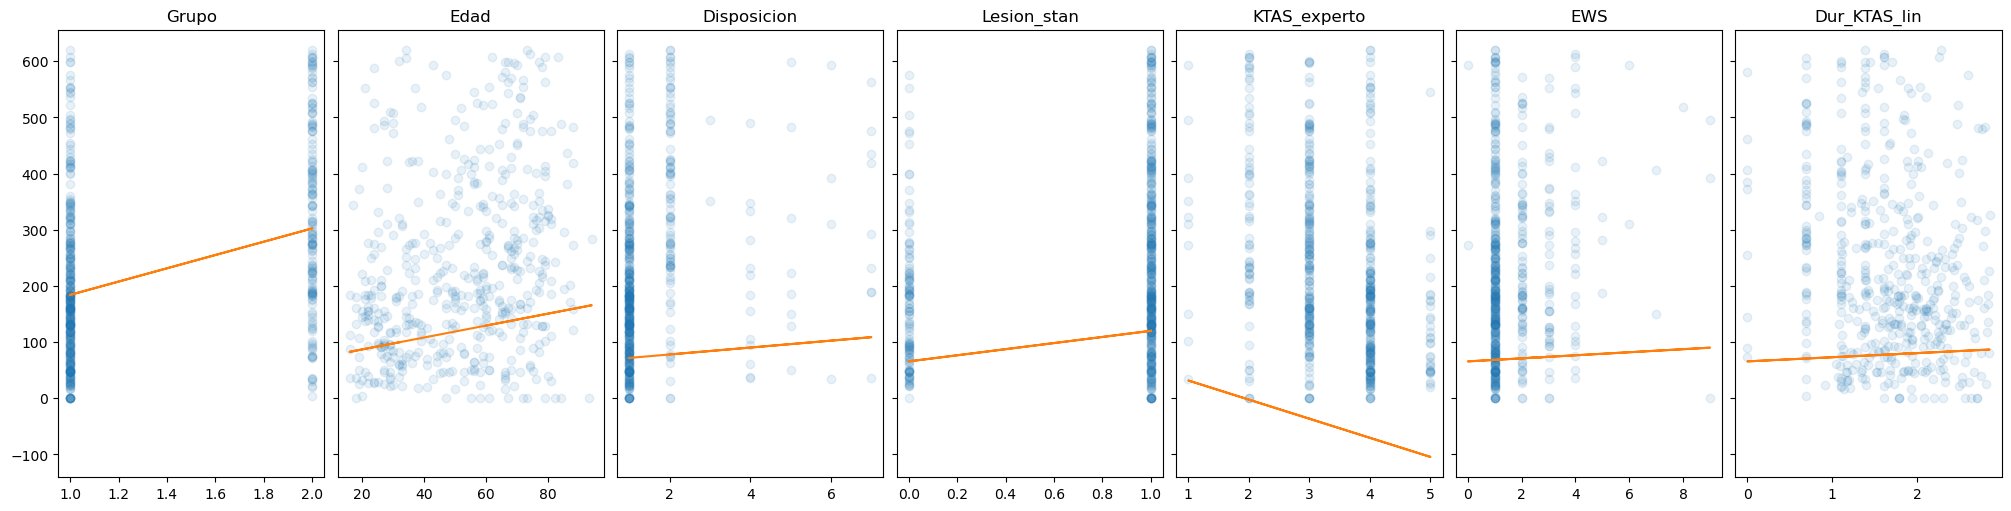

In [45]:
f, axs = plt.subplots(1, len(candidatas), sharey=True, figsize=(20, 5), layout="constrained")

for i in range(len(candidatas)):
    col = candidatas[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))


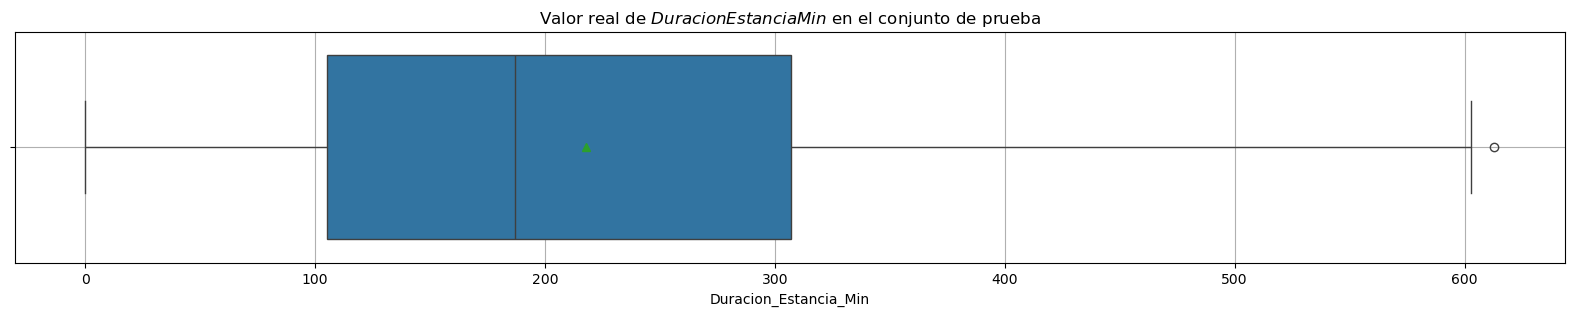

In [46]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=y_test, showmeans=True, orient="h")
plt.title("Valor real de $\t{Duracion Estancia Min}$ en el conjunto de prueba")
plt.grid()
plt.show()

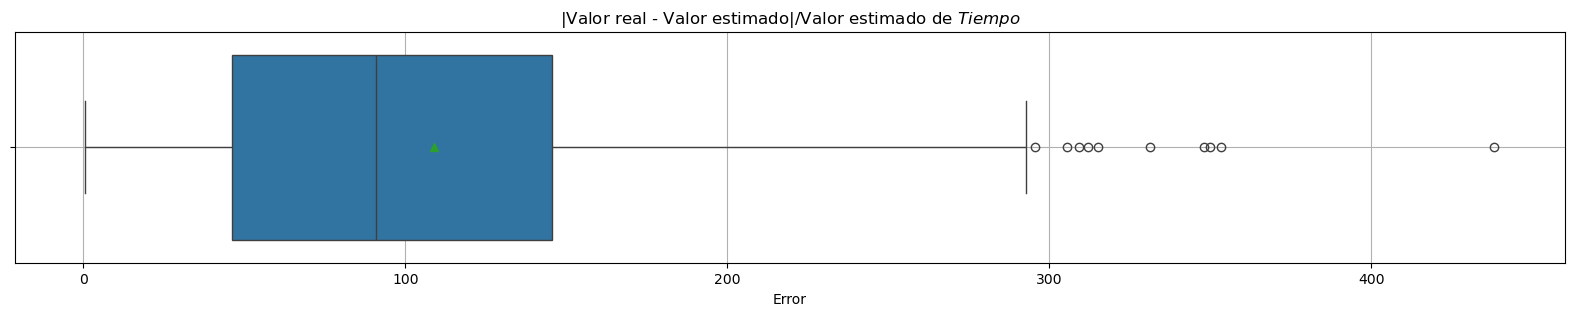

In [47]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=abs(y_test - regression.predict(X_test)), showmeans=True, orient="h")
plt.title("|Valor real - Valor estimado|/Valor estimado de $\t{Tiempo}$")
plt.xlabel("Error")
plt.grid()
plt.show()

Viendo los resultados del modelo, la edad parece estar muy dispersos, por lo que vamos a probar ignorarla, junto con la disposición.

Train: 138.3162089983082
Test: 138.2575695839281


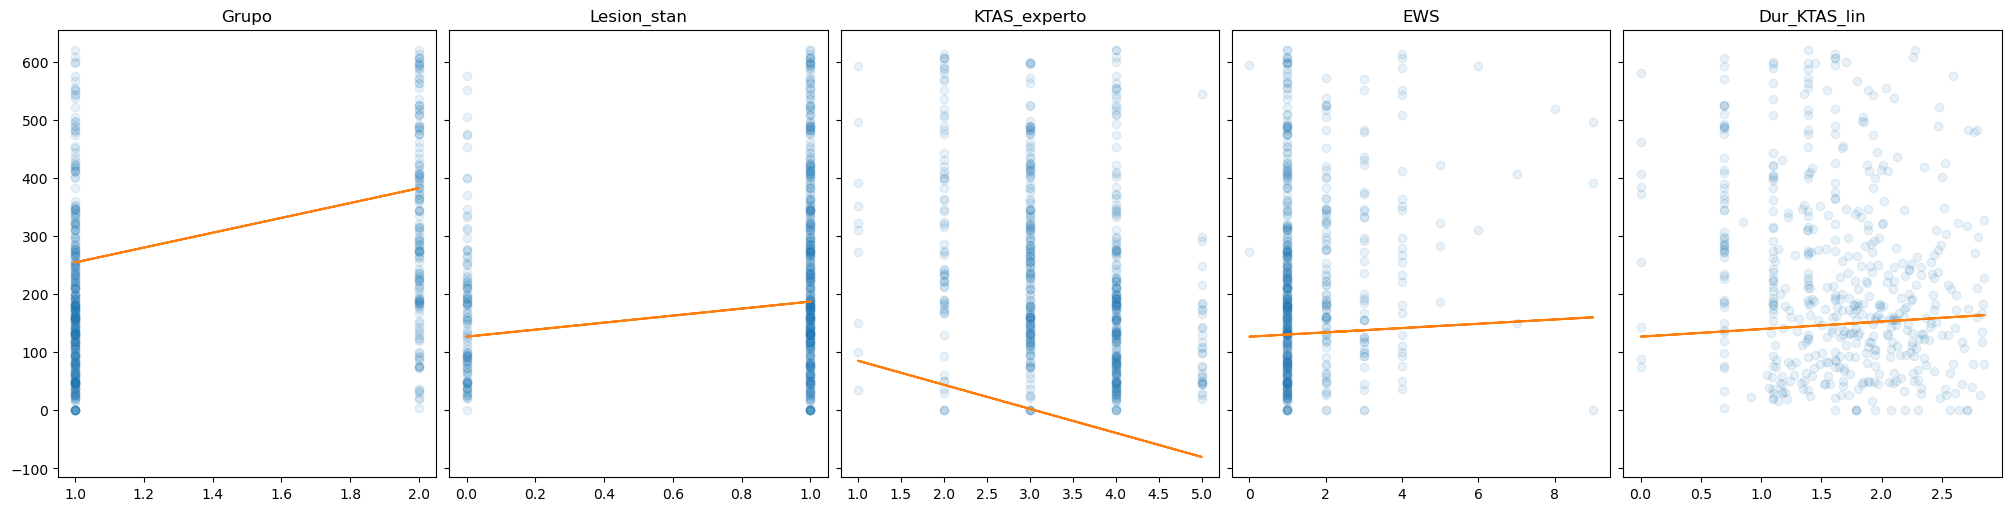

In [48]:
candidatas = ["Grupo", "Lesion_stan","KTAS_experto","EWS", "Dur_KTAS_lin"]
X_train, X_test, y_train, y_test = train_test_split(datos_recorte[candidatas], datos_recorte["Duracion_Estancia_Min"], test_size=0.3, random_state=1)
X_train.shape, y_train.shape
X_test.shape, y_test.shape
regression = LinearRegression()
regression.fit(X_train, y_train)
pd.DataFrame({"columns": candidatas, "coef": regression.coef_})
f, axs = plt.subplots(1, len(candidatas), sharey=True, figsize=(20, 5), layout="constrained")

for i in range(len(candidatas)):
    col = candidatas[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))

## 5.1 Validación de supuestos

## 5.2 Interpretación de los coeficientes

## 7. Pipeline

Para la exportación del modelo definimos funciones de trasnformación que son los pasos que deben seguir los datos de entreada para que el modelo prueda procesarlo.

En la funcion de transformación objetivos de elijen las variables que se aplicarán en el modelo de regresión.

In [49]:
         
def objetivos(X):
    X = X.copy()
    candidatas = ["grupo", "edad", "disposicion", "lesion_stan","ktas_experto","ews", "dur_ktas_lin"]
    return X[candidatas]


En la funcion de transformación limpieza se comprueba el estado de las variables de interes:
- Valores nulos: De serlo se rellena con el valor mas frecuente segun el entrenamiento
- Tipos de datos: Debes ser de tipo numerico int o float

Posterior se aplica la estarización mencioanda en la preparación de los datos.

Por ultimo se ponen todas las llaves un minuscula para evitar errores.

In [50]:

def limpieza(X):
    X.copy()
    
    X.columns = [col.lower() for col in X.columns]
    
    X['grupo'] = X['grupo'].fillna(0).astype(int)
    
    X['ktas_experto'] = X['ktas_experto'].fillna(0).astype(int)
    
    X['edad'] = X['edad'].fillna(0).astype(int)
    
    X['disposicion'] = X['disposicion'].fillna(0).astype(int)
    
    X['lesion'] = X['lesion'].fillna(0).astype(int)
    X["lesion_stan"] = X["lesion"].apply(lambda x:0 if x == 2 else x)
        
    if X["duracion_ktas_min"].dtype == 'object': 
        X["duracion_ktas_min"] = X["duracion_ktas_min"].str.replace(',', '.').astype('float64')
    elif X["duracion_ktas_min"].dtype not in ['float64', 'int64']:  
        X["duracion_ktas_min"] = pd.to_numeric(X["duracion_ktas_min"], errors='coerce').fillna(0)
    
    
    return X


Se agrupan las variables como signos vitales en un paso adicional.

In [51]:
def calcular_EWS_pipe(registro):
    total = 0
    
    # Frecuencia respiratoria (rr)
    if registro.get('rr', np.nan) <= 8:
        total += 2
    elif 9 <= registro.get('rr', np.nan) <= 14:
        total += 0
    elif 15 <= registro.get('rr', np.nan) <= 20:
        total += 1
    elif 21 <= registro.get('rr', np.nan) <= 29:
        total += 2
    elif registro.get('rr', np.nan) >= 30:
        total += 3
    
    # Presión arterial sistólica (SBP)
    if registro.get('sbp', np.nan) <= 70:
        total += 3
    elif 71 <= registro.get('sbp', np.nan) <= 80:
        total += 2
    elif 81 <= registro.get('sbp', np.nan) <= 100:
        total += 1
    elif 101 <= registro.get('sbp', np.nan) <= 199:
        total += 0
    elif registro.get('sbp', np.nan) >= 200:
        total += 2

    # Frecuencia cardíaca (HR)
    if registro.get('hr', np.nan) <= 40:
        total += 2
    elif 41 <= registro.get('hr', np.nan) <= 50:
        total += 1
    elif 51 <= registro.get('hr', np.nan) <= 100:
        total += 0
    elif 101 <= registro.get('hr', np.nan) <= 110:
        total += 1
    elif 111 <= registro.get('hr', np.nan) <= 129:
        total += 2
    elif registro.get('hr', np.nan) >= 130:
        total += 3

    # Temperatura corporal (BT)
    if registro.get('bt', np.nan) < 35.0:
        total += 2
    elif 35.0 <= registro.get('bt', np.nan) <= 38.4:
        total += 0
    elif registro.get('bt', np.nan) >= 38.5:
        total += 2

    # Saturación de oxígeno (Saturacion)
    if registro.get('saturacion', np.nan) <= 91:
        total += 3
    elif 92 <= registro.get('saturacion', np.nan) <= 93:
        total += 2
    elif 94 <= registro.get('saturacion', np.nan) <= 95:
        total += 1

    # Nivel de conciencia
    if registro.get('estado_mental', np.nan) == 1:
        total += 0
    elif registro.get('estado_mental', np.nan) == 2:
        total += 1
    elif registro.get('estado_mental', np.nan) == 3:
        total += 2
    elif registro.get('estado_mental', np.nan) == 4:
        total += 3

    return total

def agrupar_signos_vitales(X):
        X.copy()
        X['ews'] = X.apply(calcular_EWS_pipe, axis=1)
        return X

Se ordenan las intrucciones en el pipe line. La ultima instrucción "Regresión" corresponde a la linealización de los datos.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(datos_recorte, datos_recorte["Duracion_Estancia_Min"], test_size=0.3, random_state=1)

# Crear el pipeline
pipe = Pipeline([
    ('limpieza', FunctionTransformer(limpieza, validate=False)),
    ('Agrupacion', FunctionTransformer(agrupar_signos_vitales, validate=False)),
    ('objetivo', FunctionTransformer(objetivos, validate=False)),
    ('Regresion', LinearRegression())
])

# Entrenar el pipeline
pipe.fit(X_train, y_train).score(X_test, y_test)


0.15095846899671395

Una vez armado y entrenado el modelo, se guarda en el archivo "modelo_regresion_MediAlpes" para su posterior utilización.

In [53]:
dump(pipe, 'modelo_regresion_MediAlpes.pkl', compress=3)
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


A continuacion se muestra un ejemplo de carga y ejecución del modelo

In [54]:
candidatas = ["grupo", "lesion_stan","ktas_experto","ews", "dur_ktas_lin"]
registro_prueba = datos_recorte.sample(1)
modelo_cargado = load('modelo_regresion_MediAlpes.pkl')
y_pred = modelo_cargado.predict(registro_prueba)
print(f"Para el registro\n{registro_prueba[candidatas]}\n. Se estima una duración de la estancia de {y_pred} minutos")

Para el registro
     grupo  lesion_stan  ktas_experto  ews  dur_ktas_lin
323      1            0             4    3      1.609438
. Se estima una duración de la estancia de [131.83758309] minutos


## 8. Generar predicciones

Para realizar las prediciones con el modelo generado se cargan los datos y el modelo.

In [55]:
datos_sin_etiquetas = pd.read_csv("./data/Regresión_validation_data.csv")
modelo = load('modelo_regresion_MediAlpes.pkl')

Se aplica el modelo a los datos sin etiqueta.

In [56]:
Duracion_Est_min_prediccion = modelo.predict(datos_sin_etiquetas)
Duracion_Est_min_prediccion

array([262.96956934, 328.87557498, 396.42459226, 314.97675225,
       180.97273254, 165.42903141, 342.66715784, 430.04092379,
       125.86619598, 103.56219401, 365.00688918, 242.54426935,
       350.11818892, 167.3444466 , 135.34196316, 211.14186096,
       159.13365399, 263.05415958, 230.21075811, 266.6416933 ,
       376.91939711, 325.18109193, 203.81449499, 239.45934749,
       215.98634446, 336.03379946, 382.6236249 , 348.57762999,
       206.8160252 , 194.99938722, 389.66222077, 358.57242485,
       182.92389621, 236.05691492, 314.09079538, 226.65565412,
       349.19081412, 237.45834208, 359.67246523, 166.3983946 ,
       124.58100916, 319.50970824, 366.8729183 , 181.89057028,
       345.6039737 , 100.42017578, 240.67052909, 186.72677699,
       324.30929833, 214.10988769, 243.82915365, 360.95514935,
       377.50643163, 257.71788262, 178.35402188, 231.27455484,
       327.72687272, 181.47953087, 242.06698037, 148.53078473,
       350.11818892, 211.12098771, 235.15847869, 296.77

Se unen las predicciones con los datos sin entiqueta.

In [57]:
datos_predicion = pd.concat([datos_sin_etiquetas, pd.Series(Duracion_Est_min_prediccion, name = "Duracion_Estancia_Min")], axis = 1)
datos_predicion

,grupo,sexo,edad,modo_llegada,lesion,queja_principal,estado_mental,dolor,dolor_nrs,sbp,...,disposicion,grupo_de_error,duracion_ktas_min,error_triaje,ktas_enfermera,ktas_experto,lesion_stan,dur_ktas_lin,ews,Duracion_Estancia_Min
0,2,1,41,3,2,Open Wound,1,1,3,120.0,...,1,0,4.00,0,3,3,0,1.386294,1,262.969569
1,1,1,63,2,1,arrest,4,0,#BOÞ!,NaN,...,6,0,5.42,0,1,1,1,1.690096,3,328.875575
2,2,2,76,2,1,dyspnea,1,1,3,110.0,...,2,0,5.00,0,2,2,1,1.609438,1,396.424592
3,2,1,73,4,1,fever,1,0,#BOÞ!,100.0,...,1,0,2.00,0,4,4,1,0.693147,2,314.976752
4,1,1,24,3,1,Near syncope,1,0,#BOÞ!,139.0,...,1,0,4.05,0,3,3,1,1.398717,1,180.972733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2,2,62,3,1,dyspnea,1,1,3,110.0,...,2,0,4.00,0,2,2,1,1.386294,1,379.884603
296,1,2,56,3,1,RLQ abd. pain,1,1,4,163.0,...,5,0,5.75,0,3,3,1,1.749200,1,242.227233
297,2,2,48,2,1,right chest pain,1,1,5,120.0,...,1,0,4.00,0,2,2,1,1.386294,1,358.834853
298,2,1,29,3,2,foreign body ingestion,1,1,6,140.0,...,1,0,5.00,0,3,3,0,1.609438,1,251.850844


Se guarda en un archivo los resultados de las predicciones con la llave "Duracion_Estancia_Min"

In [888]:
datos_predicion.to_csv("./data/Regresión_predict_data.csv", sep=',', index=False, encoding='utf-8')

## Procesamiento de texto

In [150]:
datos['Queja_Principal'].info()

<class 'pandas.core.series.Series'>
Index: 952 entries, 0 to 966
Series name: Queja_Principal
Non-Null Count  Dtype 
--------------  ----- 
952 non-null    object
dtypes: object(1)
memory usage: 14.9+ KB


In [151]:
textos = datos.copy()
textos['Conteo'] = [len(x) for x in textos['Queja_Principal']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Queja_Principal']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Queja_Principal']]
textos[["Queja_Principal", "Conteo", "Max",	"Min"]]

,Queja_Principal,Conteo,Max,Min
0,ant. chest pain,15,5,4
1,headache,8,8,8
2,ant. chest pain,15,5,4
3,headache,8,8,8
4,fever & chill,13,5,1
...,...,...,...,...
962,dysarthria,10,10,10
963,DZ - Dizziness,14,9,1
964,dysarthria,10,10,10
965,sexual violence,15,8,6


In [152]:

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        if word:  # Verifica que la palabra no sea None o una cadena vacía
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = [word.lower() for word in words if word]  # Usa comprensión de listas
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = [re.sub(r'[^\w\s]', '', word) for word in words if word]  # Usa comprensión de listas
    return [word for word in new_words if word]

#def replace_numbers(words):
#    """Replace all interger occurrences in list of tokenized words with textual representation"""
#    p = inflect.engine()
#    print(words)
#    new_words = []
#    for word in words:
#        if word.isdigit():
#            new_word = p.number_to_words(word)
#            new_words.append(new_word)
#            print("if " + new_word)
#        else:
#            new_words.append(word)
#    return new_words

def lemmatize_words(words):
    """Lemmatize list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return lemmatized_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    stop_words = set(stopwords.words('english'))  # Usa un set para búsquedas más rápidas
    filtered_words = [word for word in words if word not in stop_words]
    return filtered_words

def preprocessing(words):
    words = to_lowercase(words)
#   words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    words = lemmatize_words(words)
    return words

In [153]:
datos['Queja_Principal'] = datos['Queja_Principal'].apply(contractions.fix)

In [154]:
datos['words'] = datos['Queja_Principal'].apply(lambda x: preprocessing(word_tokenize(x)))
datos['words1']=datos['words'].apply(preprocessing)
datos['words'] = datos['words1'].apply(lambda x: ' '.join(map(str, x)))
datos['words'].dropna()

datos.head()


,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,Sexo_stan,Lesion_stan,EWS,Dur_KTAS_lin,words,words1
0,2,2,49,2,1,ant. chest pain,1,1,2,150.0,...,0,1591,2.0,0,0,1,1,0.693147,ant chest pain,"[ant, chest, pain]"
1,2,2,30,4,1,headache,1,1,4,140.0,...,0,211,3.0,0,0,1,1,1.098612,headache,[headache]
2,2,1,61,3,2,ant. chest pain,1,1,3,100.0,...,0,119,2.0,0,1,0,2,0.693147,ant chest pain,"[ant, chest, pain]"
3,2,2,61,3,1,headache,1,1,4,120.0,...,4,414,2.0,2,0,1,1,0.693147,headache,[headache]
4,1,2,67,3,1,fever & chill,1,0,0,143.0,...,1,267,3.6,2,0,1,4,1.280934,fever chill,"[fever, chill]"


In [155]:
X_data, y_data = datos['words'],datos['Duracion_Estancia_Min']


In [256]:
dummy = CountVectorizer(binary=True)
X_dummy = dummy.fit_transform(X_data)  # X_data es tu lista de textos
print(X_dummy.shape)

# Paso 2: Convertir a DataFrame (esto es opcional si solo quieres ver los datos en formato de tabla)
X_dense = X_dummy.toarray()
X_df = pd.DataFrame(X_dense, columns=dummy.get_feature_names_out())

# Paso 3: Aplicar TF-IDF usando TfidfTransformer
tt = TfidfTransformer(norm='l2', use_idf=True)
tt_matrix = tt.fit_transform(X_dummy)  # Usa X_dummy directamente

# Paso 4: Convertir a una matriz densa si es necesario para inspección o para usarla en otro proceso
tt_matrix_dense = tt_matrix.toarray()

# Paso 5: Crear DataFrame con la matriz TF-IDF
vocab = dummy.get_feature_names_out()
tt_df = pd.DataFrame(np.round(tt_matrix_dense, 2), columns=vocab)
tt_df["abdomen"].value_counts()

pd.DataFrame([df], columns=feature_names)


(952, 269)


abdomen
0.00    942
0.93      8
0.61      1
0.75      1
Name: count, dtype: int64

In [ ]:
# Convertir cada fila de la matriz en una lista
rows_as_lists = np.round(tt_matrix_dense, 2).tolist()

# Crear un DataFrame donde cada fila es una lista
tt_df = pd.DataFrame(rows_as_lists)

# Convertir las filas del DataFrame en una sola columna
tt_df = pd.DataFrame({'vector_palabras': tt_df.values.tolist()})

tt_df

In [247]:
datos_vector = datos.reset_index()
datos_vector = pd.concat([datos_vector, tt_df], axis=1)
datos_vector

,index,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,...,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,Sexo_stan,Lesion_stan,EWS,Dur_KTAS_lin,words,words1,vector_palabras
0,0,2,2,49,2,1,ant. chest pain,1,1,2,...,1591,2.00,0,0,1,1,0.693147,ant chest pain,"[ant, chest, pain]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,2,2,30,4,1,headache,1,1,4,...,211,3.00,0,0,1,1,1.098612,headache,[headache],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,2,1,61,3,2,ant. chest pain,1,1,3,...,119,2.00,0,1,0,2,0.693147,ant chest pain,"[ant, chest, pain]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,2,2,61,3,1,headache,1,1,4,...,414,2.00,2,0,1,1,0.693147,headache,[headache],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,1,2,67,3,1,fever & chill,1,0,0,...,267,3.60,2,0,1,4,1.280934,fever chill,"[fever, chill]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,962,2,2,64,3,1,dysarthria,1,0,0,...,356,2.00,0,0,1,1,0.693147,dysarthria,[dysarthria],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
948,963,2,1,70,3,1,DZ - Dizziness,1,0,0,...,456,4.00,0,1,1,1,1.386294,dz dizziness,"[dz, dizziness]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
949,964,2,1,75,3,1,dysarthria,1,0,0,...,278,2.00,0,1,1,1,0.693147,dysarthria,[dysarthria],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
950,965,1,1,26,3,2,sexual violence,1,0,0,...,199,11.32,0,1,0,1,2.426571,sexual violence,"[sexual, violence]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [248]:

X_train, X_test, y_train, y_test = train_test_split(datos_vector, y_data, test_size=0.3, random_state=42)

In [249]:
regressor = LinearRegression()

# Entrenar el modelo
regressor.fit(X_train, y_train)

ValueError: could not convert string to float: 'hypoglycemic'

In [ ]:
print("Train:", np.sqrt(mean_squared_error(y_train, regressor.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regressor.predict(X_test))))

array([[0, 1],
       [0, 2]])

In [189]:
regressor = LinearRegression()
# Entrenar el modelo
regressor.fit([np.array([0,1]), np.array([0,2])], [np.array([1,0]), np.array([2,0])])

LinearRegression()

array([[10.,  0.],
       [ 2.,  0.]])